In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train1/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train1/osteoarthritis',224))
# normal_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/normal',224))
# osteoarthritis_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis',224))

100%|██████████| 2026/2026 [00:13<00:00, 149.27it/s]


In [ ]:
print(len(normal_train))
print(len(osteoarthritis_train))
# print(len(normal_test))
# print(len(osteoarthritis_test))

1589
2026


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))
# normal_test_label = np.zeros(len(normal_test))
# osteoarthritis_test_label = np.ones(len(osteoarthritis_test))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)
# X_test = np.concatenate((normal_test, osteoarthritis_test), axis = 0)
# Y_test = np.concatenate((normal_test_label, osteoarthritis_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
# s = np.arange(X_test.shape[0])
# np.random.shuffle(s)
# X_test = X_test[s]
# Y_test = Y_test[s]


In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
# Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

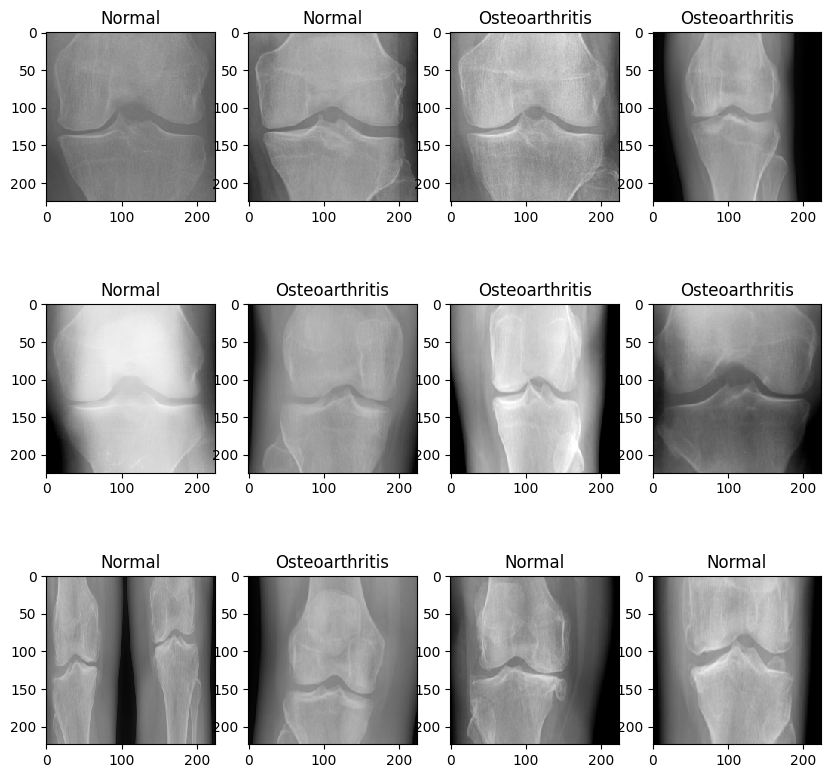

In [ ]:
# # Display first 15 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        # zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

# dennet   = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
nas      = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg      = tf.keras.applications.VGG19(include_top=False, input_shape=input_shape)(inputs)

In [ ]:
outputs = GlobalAveragePooling2D()(vgg)
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(64,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256   

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-17-9d9ad6683064>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
91/90 [==============================] - ETA: 0s - loss: 0.7798 - accuracy: 0.5124

90/90 [==============================] - 89s 791ms/step - loss: 0.7798 - accuracy: 0.5124 - val_loss: 2.5095 - val_accuracy: 0.4426 - lr: 1.0000e-04
Epoch 2/40
91/90 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.4972

90/90 [==============================] - 62s 688ms/step - loss: 0.7459 - accuracy: 0.4972 - val_loss: 4.0853 - val_accuracy: 0.4426 - lr: 1.0000e-04
Epoch 3/40
91/90 [==============================] - ETA: 0s - loss: 0.7242 - accuracy: 0.5173

90/90 [==============================] - 62s 680ms/step - loss: 0.7242 - accuracy: 0.5173 - val_loss: 2.3477 - val_accuracy: 0.4426 - lr: 1.0000e-04
Epoch 4/40
91/90 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.5204

90/90 [==============================] - 62s 682ms/step - loss: 0.7133 - accuracy: 0.5204 - val_loss: 1.8708 - val_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 5/40
91/90 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.5387

90/90 [==============================] - 63s 700ms/step - loss: 0.7085 - accuracy: 0.5387 - val_loss: 1.4420 - val_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 6/40
91/90 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5415

90/90 [==============================] - 62s 686ms/step - loss: 0.6955 - accuracy: 0.5415 - val_loss: 1.8404 - val_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 7/40
91/90 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5484

90/90 [==============================] - 62s 680ms/step - loss: 0.6915 - accuracy: 0.5484 - val_loss: 1.1448 - val_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 8/40
91/90 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.5996

90/90 [==============================] - 63s 690ms/step - loss: 0.6535 - accuracy: 0.5996 - val_loss: 0.9371 - val_accuracy: 0.5353 - lr: 1.0000e-04
Epoch 9/40
91/90 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.6466

90/90 [==============================] - 62s 689ms/step - loss: 0.6222 - accuracy: 0.6466 - val_loss: 1.1820 - val_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 10/40
91/90 [==============================] - ETA: 0s - loss: 0.5706 - accuracy: 0.7047

90/90 [==============================] - 61s 676ms/step - loss: 0.5706 - accuracy: 0.7047 - val_loss: 0.9173 - val_accuracy: 0.5173 - lr: 1.0000e-04
Epoch 11/40
91/90 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7185

90/90 [==============================] - 62s 688ms/step - loss: 0.5504 - accuracy: 0.7185 - val_loss: 1.8363 - val_accuracy: 0.4467 - lr: 1.0000e-04
Epoch 12/40
91/90 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.7510

90/90 [==============================] - 63s 695ms/step - loss: 0.5085 - accuracy: 0.7510 - val_loss: 0.9751 - val_accuracy: 0.5740 - lr: 1.0000e-04
Epoch 13/40
91/90 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.7569

90/90 [==============================] - 61s 675ms/step - loss: 0.5010 - accuracy: 0.7569 - val_loss: 0.6073 - val_accuracy: 0.7289 - lr: 1.0000e-04
Epoch 14/40
91/90 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.7773

90/90 [==============================] - 63s 700ms/step - loss: 0.4809 - accuracy: 0.7773 - val_loss: 0.9428 - val_accuracy: 0.5920 - lr: 1.0000e-04
Epoch 15/40
91/90 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7759

90/90 [==============================] - 63s 693ms/step - loss: 0.4843 - accuracy: 0.7759 - val_loss: 0.5140 - val_accuracy: 0.7911 - lr: 1.0000e-04
Epoch 16/40
91/90 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.7877

90/90 [==============================] - 62s 678ms/step - loss: 0.4608 - accuracy: 0.7877 - val_loss: 0.5112 - val_accuracy: 0.8077 - lr: 1.0000e-04
Epoch 17/40
91/90 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7863

90/90 [==============================] - 62s 682ms/step - loss: 0.4547 - accuracy: 0.7863 - val_loss: 1.0623 - val_accuracy: 0.5118 - lr: 1.0000e-04
Epoch 18/40
91/90 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.7880

90/90 [==============================] - 63s 696ms/step - loss: 0.4462 - accuracy: 0.7880 - val_loss: 1.6619 - val_accuracy: 0.4772 - lr: 1.0000e-04
Epoch 19/40
91/90 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.7936

90/90 [==============================] - 63s 691ms/step - loss: 0.4490 - accuracy: 0.7936 - val_loss: 0.5392 - val_accuracy: 0.7593 - lr: 1.0000e-04
Epoch 20/40
91/90 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.8039

90/90 [==============================] - 62s 681ms/step - loss: 0.4295 - accuracy: 0.8039 - val_loss: 0.4620 - val_accuracy: 0.8271 - lr: 1.0000e-04
Epoch 21/40
91/90 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.8223

90/90 [==============================] - 63s 699ms/step - loss: 0.4019 - accuracy: 0.8223 - val_loss: 0.5246 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 22/40
91/90 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8064

90/90 [==============================] - 60s 663ms/step - loss: 0.4143 - accuracy: 0.8064 - val_loss: 0.4843 - val_accuracy: 0.7981 - lr: 1.0000e-04
Epoch 23/40
91/90 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8243

90/90 [==============================] - 61s 668ms/step - loss: 0.3866 - accuracy: 0.8243 - val_loss: 0.3956 - val_accuracy: 0.8423 - lr: 1.0000e-04
Epoch 24/40
91/90 [==============================] - ETA: 0s - loss: 0.4056 - accuracy: 0.8098

90/90 [==============================] - 64s 698ms/step - loss: 0.4056 - accuracy: 0.8098 - val_loss: 0.7396 - val_accuracy: 0.6376 - lr: 1.0000e-04
Epoch 25/40
91/90 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8257

90/90 [==============================] - 61s 671ms/step - loss: 0.3806 - accuracy: 0.8257 - val_loss: 0.4331 - val_accuracy: 0.8036 - lr: 1.0000e-04
Epoch 26/40
91/90 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8257

90/90 [==============================] - 62s 684ms/step - loss: 0.3845 - accuracy: 0.8257 - val_loss: 0.6685 - val_accuracy: 0.8230 - lr: 1.0000e-04
Epoch 27/40
91/90 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8416

90/90 [==============================] - 62s 683ms/step - loss: 0.3694 - accuracy: 0.8416 - val_loss: 0.5442 - val_accuracy: 0.7939 - lr: 1.0000e-04
Epoch 28/40
91/90 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8295

90/90 [==============================] - 60s 663ms/step - loss: 0.3801 - accuracy: 0.8295 - val_loss: 0.7614 - val_accuracy: 0.6916 - lr: 1.0000e-04
Epoch 29/40
91/90 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8385

90/90 [==============================] - 62s 683ms/step - loss: 0.3654 - accuracy: 0.8385 - val_loss: 0.5231 - val_accuracy: 0.7718 - lr: 1.0000e-04
Epoch 30/40
91/90 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8479

90/90 [==============================] - 62s 681ms/step - loss: 0.3522 - accuracy: 0.8479 - val_loss: 0.3624 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 31/40
91/90 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8406

90/90 [==============================] - 62s 689ms/step - loss: 0.3594 - accuracy: 0.8406 - val_loss: 0.3384 - val_accuracy: 0.8686 - lr: 1.0000e-04
Epoch 32/40
91/90 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8444

90/90 [==============================] - 62s 689ms/step - loss: 0.3560 - accuracy: 0.8444 - val_loss: 0.4044 - val_accuracy: 0.8396 - lr: 1.0000e-04
Epoch 33/40
91/90 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8548

90/90 [==============================] - 63s 698ms/step - loss: 0.3341 - accuracy: 0.8548 - val_loss: 0.4292 - val_accuracy: 0.8285 - lr: 1.0000e-04
Epoch 34/40
91/90 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8375

90/90 [==============================] - 62s 683ms/step - loss: 0.3597 - accuracy: 0.8375 - val_loss: 0.3174 - val_accuracy: 0.8686 - lr: 1.0000e-04
Epoch 35/40
91/90 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8510

90/90 [==============================] - 60s 661ms/step - loss: 0.3452 - accuracy: 0.8510 - val_loss: 0.4513 - val_accuracy: 0.7925 - lr: 1.0000e-04
Epoch 36/40
91/90 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8444

90/90 [==============================] - 63s 699ms/step - loss: 0.3363 - accuracy: 0.8444 - val_loss: 1.0726 - val_accuracy: 0.5934 - lr: 1.0000e-04
Epoch 37/40
91/90 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8485

90/90 [==============================] - 61s 672ms/step - loss: 0.3446 - accuracy: 0.8485 - val_loss: 0.3130 - val_accuracy: 0.8728 - lr: 1.0000e-04
Epoch 38/40
91/90 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.8503

90/90 [==============================] - 60s 661ms/step - loss: 0.3334 - accuracy: 0.8503 - val_loss: 0.4833 - val_accuracy: 0.7552 - lr: 1.0000e-04
Epoch 39/40
91/90 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8499

90/90 [==============================] - 61s 679ms/step - loss: 0.3317 - accuracy: 0.8499 - val_loss: 0.5170 - val_accuracy: 0.7787 - lr: 1.0000e-04
Epoch 40/40
91/90 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8558

90/90 [==============================] - 62s 683ms/step - loss: 0.3249 - accuracy: 0.8558 - val_loss: 0.3498 - val_accuracy: 0.8797 - lr: 1.0000e-04


23/23 [==============================] - 4s 157ms/step
Confusion matrix, without normalization
[[292  28]
 [ 59 344]]


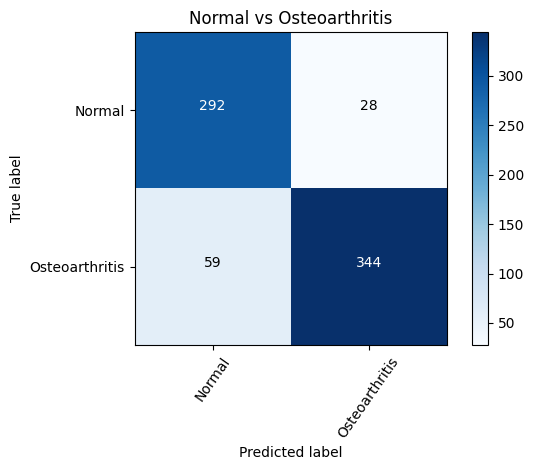

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

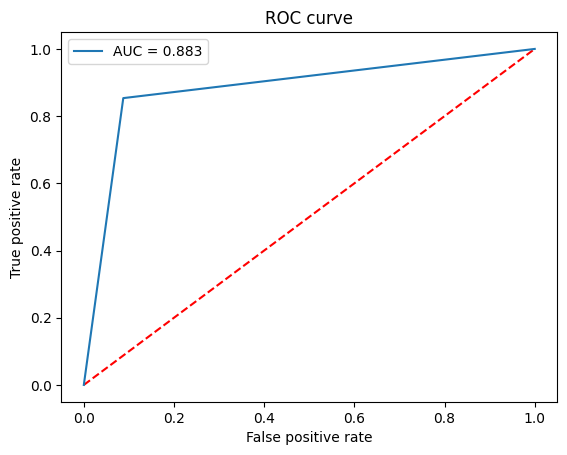

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:

i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Normal"
    else:
        return "Osteoarthritis"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result: "+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

NameError: ignored

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

23/23 [==============================] - 3s 142ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Normal', 'Osteoarthritis']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

        Normal       0.83      0.91      0.87       320
Osteoarthritis       0.92      0.85      0.89       403

      accuracy                           0.88       723
     macro avg       0.88      0.88      0.88       723
  weighted avg       0.88      0.88      0.88       723

